# **Written by Deepak Yadav**

### **Waste Garbage Classification Using  Pre-train VGG - 16 Using Transfer Learning and Fine Tuning** 

The difference between Transfer Learning and Fine-Tuning is that 

* In Transfer Learning, we only optimize the weights of the new classification layers we have added, while we keep the weights of the original VGG16 model. 

* In Fine-Tuning we optimize both the weights of the new classification layers we have added, as well as some or all of the layers from the VGG16 model.

# **Transfer Learning Architecture**

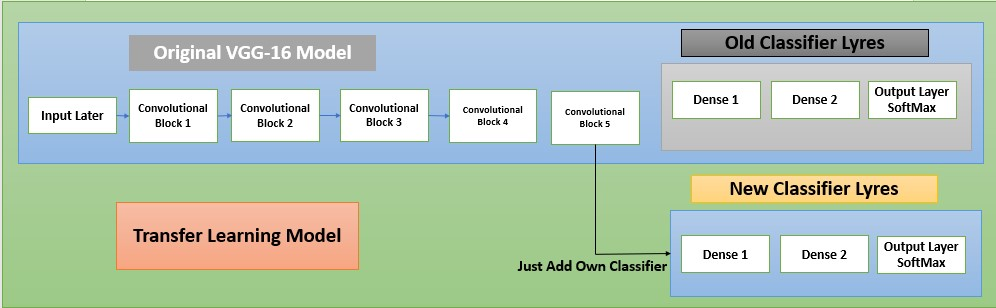

# **Fine Tuning Architecture**

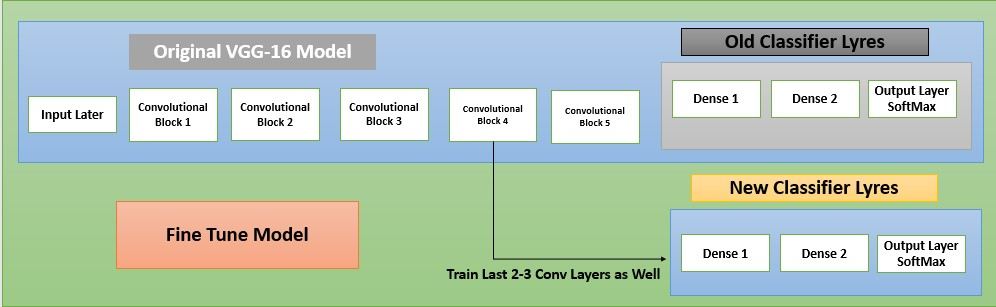

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
import sklearn 
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image as im
import cv2

In [20]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [21]:
BATCH_SIZE = 64
img_height = 244
img_width = 244

# **Load Datasets**

In [22]:
import os
data_path = '/content/drive/MyDrive/Data_Garbadge/Garbage_Data'
os.listdir(data_path)

['train', 'test']

In [23]:
input_path = data_path
train_data_dir = input_path + '/' + 'train'
test_data_dir = input_path + '/' + 'test'

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 2187 files belonging to 7 classes.
Using 1750 files for training.


In [26]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 2187 files belonging to 7 classes.
Using 437 files for validation.


In [27]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']


# **DataSets Visualizations**

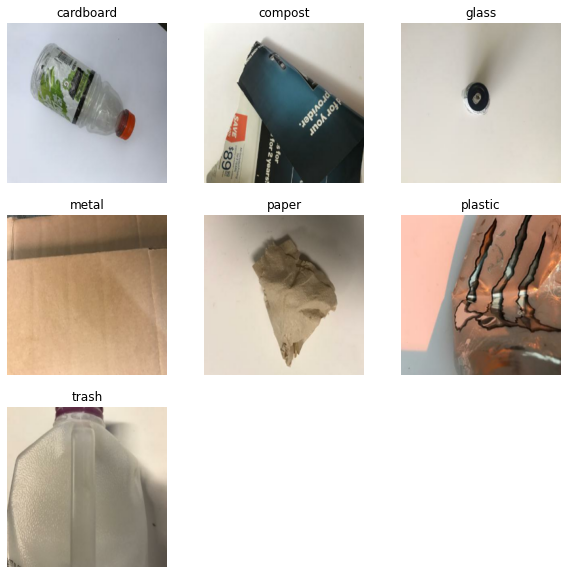

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [30]:
data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
])

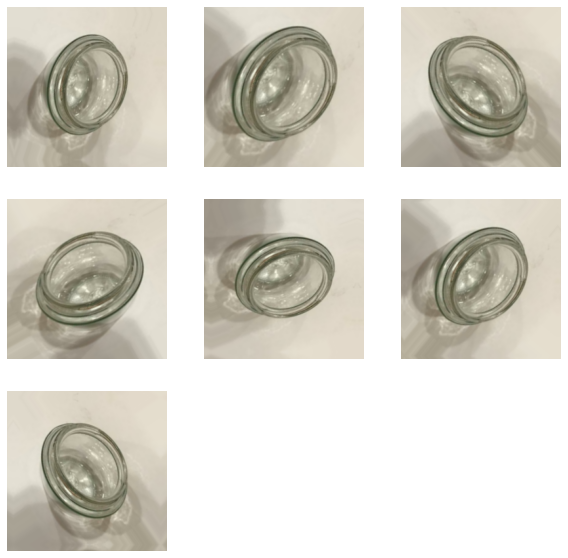

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
   # plt.title(class_names[2])
    plt.axis("off")

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# **Model Architecture** 

*   **VGG-16 Base Model**







In [33]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [34]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [35]:
print_layer_trainable()

True:	input_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


**Fix the weights**

In [36]:
base_model.trainable = False

In [37]:
for layer in base_model.layers:
    layer.trainable = False

In [38]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [41]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(1072, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

### **Transfer Learning**







In [42]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 4096)              2101248   
                                                                 
 dense_3 (Dense)             (None, 1072)              4391984   
                                                      

In [43]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [44]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [45]:
%%time
history = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/20
28/28 [==============================] - 365s 4s/step - loss: 1.8404 - accuracy: 0.3023 - val_loss: 1.3503 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 2/20
28/28 [==============================] - 24s 858ms/step - loss: 1.2758 - accuracy: 0.4726 - val_loss: 1.1379 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 3/20
28/28 [==============================] - 24s 864ms/step - loss: 1.1233 - accuracy: 0.5451 - val_loss: 1.0477 - val_accuracy: 0.5927 - lr: 0.0010
Epoch 4/20
28/28 [==============================] - 24s 864ms/step - loss: 1.0217 - accuracy: 0.6131 - val_loss: 1.0414 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 5/20
28/28 [==============================] - 24s 868ms/step - loss: 0.9430 - accuracy: 0.6480 - val_loss: 0.9695 - val_accuracy: 0.6499 - lr: 0.0010
Epoch 6/20
28/28 [==============================] - 24s 865ms/step - loss: 0.8767 - accuracy: 0.6663 - val_loss: 0.9321 - val_accuracy: 0.6476 - lr: 0.0010
Epoch 7/20
28/28 [==============================] - 24s 867ms/step

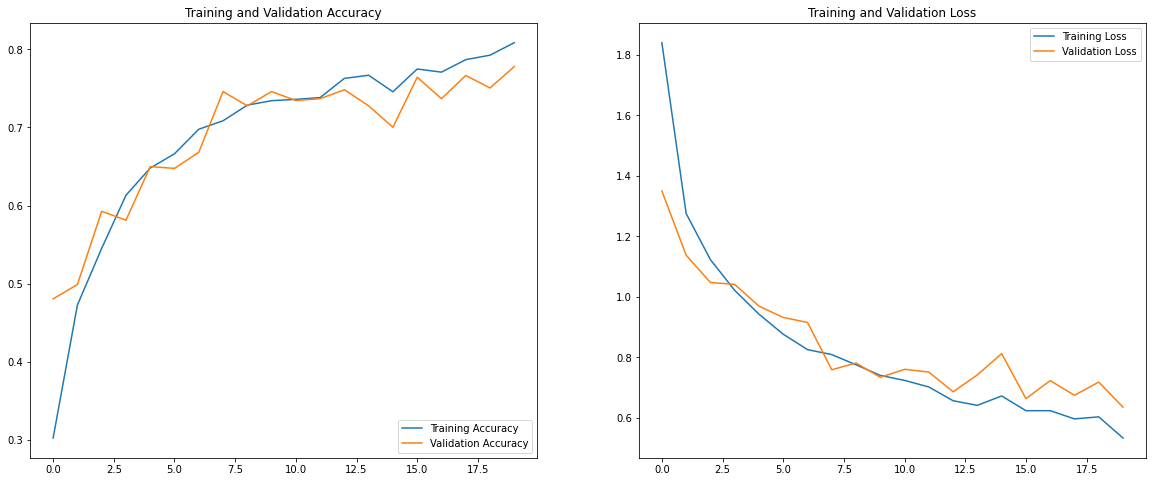

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [85]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 564 files belonging to 7 classes.


In [48]:
# Generate predictions
model.load_weights('/content/vgg16_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

In [93]:
model.evaluate(test_ds, verbose = 1)

564/564 [==============================] - 24s 42ms/step - loss: 0.7807 - accuracy: 0.7394


[0.7807128429412842, 0.7393617033958435]

# **Fine Tuning**

In [94]:
fine_tune  = base_model

In [95]:
fine_tune.trainable = True

In [96]:
for layer in fine_tune.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [97]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [98]:
fine_tune.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [105]:
n_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    fine_tune,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(1072, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [106]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 4096)              2101248   
                                                                 
 dense_8 (Dense)             (None, 1072)              4391984   
                                                      

In [107]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [108]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights_fine_tuning.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [110]:
%%time
history = model2.fit(train_ds,
                    epochs = 25,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/25
28/28 [==============================] - 32s 1s/step - loss: 1.5714 - accuracy: 0.3291 - val_loss: 1.7697 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 2/25
28/28 [==============================] - 31s 1s/step - loss: 1.4182 - accuracy: 0.4023 - val_loss: 1.8257 - val_accuracy: 0.2952 - lr: 0.0010
Epoch 3/25
28/28 [==============================] - 32s 1s/step - loss: 1.2384 - accuracy: 0.5103 - val_loss: 1.3339 - val_accuracy: 0.5057 - lr: 0.0010
Epoch 4/25
28/28 [==============================] - 31s 1s/step - loss: 1.1305 - accuracy: 0.5497 - val_loss: 1.0734 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 5/25
28/28 [==============================] - 31s 1s/step - loss: 1.1397 - accuracy: 0.5634 - val_loss: 1.1016 - val_accuracy: 0.5995 - lr: 0.0010
Epoch 6/25
28/28 [==============================] - 32s 1s/step - loss: 1.0291 - accuracy: 0.6126 - val_loss: 1.0570 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 7/25
28/28 [==============================] - 31s 1s/step - loss: 0.9786 - a

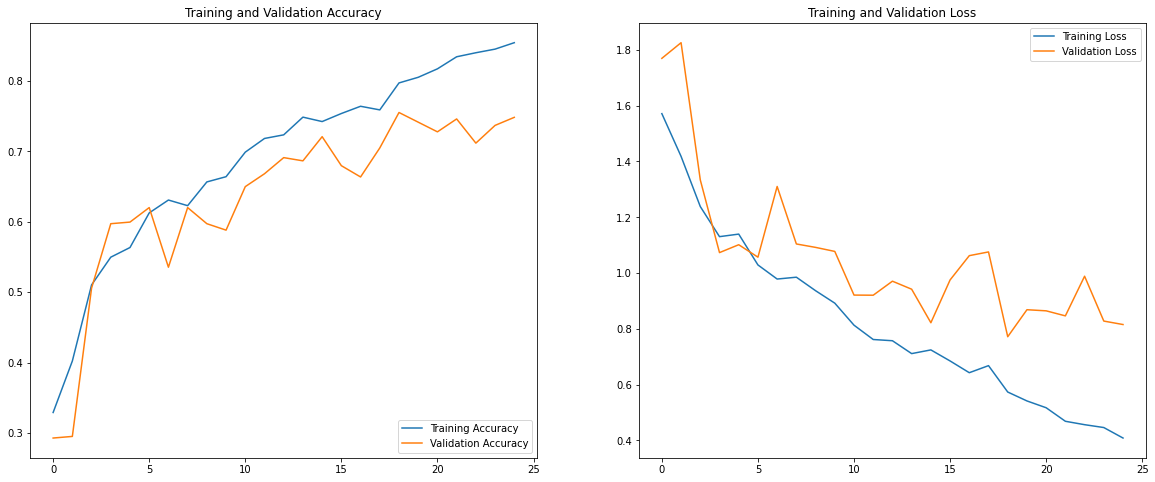

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [113]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 564 files belonging to 7 classes.


In [116]:
# Generate predictions
model2.load_weights('/content/vgg16_best_weights_fine_tuning.hdf5') # initialize the best trained weights
preds = model2.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

In [117]:
model2.evaluate(test_ds, verbose = 1)

564/564 [==============================] - 23s 40ms/step - loss: 0.7614 - accuracy: 0.7660


[0.7613944411277771, 0.7659574747085571]

# **Concludes**

**Accuracy On Transfer Learning : 73.9%** </br>
**Accuracy On Fine Tuning : 76.5%**</br>
